In [42]:
#pip install mplfinance

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import mplfinance as mpf

### Análisis Exploratorio de Datos

### A) Exploración inicial

#### Criptomonedas

In [44]:
df_criptos=pd.read_csv('./DataCriptos.csv',index_col=0,parse_dates=True)

In [45]:
df_criptos.head(2)

,Cripto,prices2,market_caps2,total_volumes2,Open,High,Low,Close,Ranking,Body_Ratio,Clasificación,Daily_Return
fechas,,,,,,,,,,,,
2022-08-21,bitcoin,21175.232733,4.049249e+11,2.380968e+10,21140.07,21800.00,21069.11,21515.61,1,0.513812,Fuerte Volatilidad,0.000000
2022-08-22,bitcoin,21615.761693,4.135789e+11,2.047624e+10,21516.70,21548.71,20890.18,21399.83,1,0.177471,Indecisión,-0.005381


In [46]:
df_criptos.shape

(3640, 12)

##### No hay valores nulos.

In [47]:
df_criptos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3640 entries, 2022-08-21 to 2023-08-19
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cripto          3640 non-null   object 
 1   prices2         3640 non-null   float64
 2   market_caps2    3640 non-null   float64
 3   total_volumes2  3640 non-null   float64
 4   Open            3640 non-null   float64
 5   High            3640 non-null   float64
 6   Low             3640 non-null   float64
 7   Close           3640 non-null   float64
 8   Ranking         3640 non-null   int64  
 9   Body_Ratio      3640 non-null   float64
 10  Clasificación   3640 non-null   object 
 11  Daily_Return    3640 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 369.7+ KB


#### Valores Duplicados

Solo se buscan valores de fechas duplicadas, ya que en las demás columnas no es coherente buscar duplicados.

In [48]:
# Agrupar por 'Cripto' y verificar duplicados en las fechas
duplicates_found = []

for cripto, group in df_criptos.groupby('Cripto'):
    duplicates_in_group = group.index.duplicated()
    
    if any(duplicates_in_group):
        duplicates_found.append((cripto, group[duplicates_in_group]))
        
# Imprimir los resultados
if duplicates_found:
    for cripto, duplicates_data in duplicates_found:
        print(f'Duplicados en {cripto}:')
        print(duplicates_data)
else:
    print('No se encontraron duplicados en ninguna criptomoneda.')

No se encontraron duplicados en ninguna criptomoneda.


#### Outliers

Dado el comportamiento de una criptomoneda es fundamental aclarar que lo que puede parecer un Outlier, puede ser un valor real. Por lo que se decide dejar a todos estos, sin embargo se realizó igualmente un anális con el Rango Intercuartil (IQR), que es la diferencia entre el tercer cuartil (Q3) y el primer cuartil (Q1) de los datos. Los valores que están por debajo de Q1 - 1.5 * IQR o por encima de Q3 + 1.5 * IQR se consideran outliers.

In [49]:
def Outliers(df, columna,var:str):
    ''' Identifica outliers
        columna: De donde se obtendran las criptos/compañia'''
    outliers = pd.DataFrame()  # Crear un DataFrame vacío para almacenar los outliers
    
    for cripto in df[columna].unique():
            cripto_df = df[df[columna] == cripto]
            
            Q1 = cripto_df[var].quantile(0.25)
            Q3 = cripto_df[var].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Filtrar los outliers y agregar la columna "Outlier" con el valor de la columna correspondiente
            outliers_column = cripto_df[(cripto_df[var] < lower_bound) | (cripto_df[var] > upper_bound)]
            outliers_column['Outlier'] = var
            outliers = pd.concat([outliers, outliers_column])  # Agregar los outliers al DataFrame
        
    return outliers

Se obtienen 71 outliers para diferentes criptomonedas en la columna precios:
4 para "solana", 10 para "hedera-hashgraph" y 57 para "bitcoin-cash"


In [50]:
outliers_df = Outliers(df_criptos, columna='Cripto',var='prices2')
outliers_df['Cripto'].unique()
#array(['solana', 'hedera-hashgraph', 'bitcoin-cash'], dtype=object)

/var/folders/gg/08x9mdfn43q02625840rv79h0000gn/T/ipykernel_3061/1400367369.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_column['Outlier'] = var
/var/folders/gg/08x9mdfn43q02625840rv79h0000gn/T/ipykernel_3061/1400367369.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_column['Outlier'] = var
/var/folders/gg/08x9mdfn43q02625840rv79h0000gn/T/ipykernel_3061/1400367369.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

array(['solana', 'hedera-hashgraph', 'bitcoin-cash'], dtype=object)

In [51]:
outliers_df[outliers_df.Cripto=='bitcoin-cash'].shape

(57, 13)

Los 57 outliers de "bitcoin-cash" deben ser la subida en el precio del tercer trimestre del año; respecto los 4 de "solana" deben ser en su baja de Diciembre del 2022 hasta su repunte, por último los  10 de "hedera-hashgraph"  deben ser en el pico de su repunte del primer trimestre del 2023. 

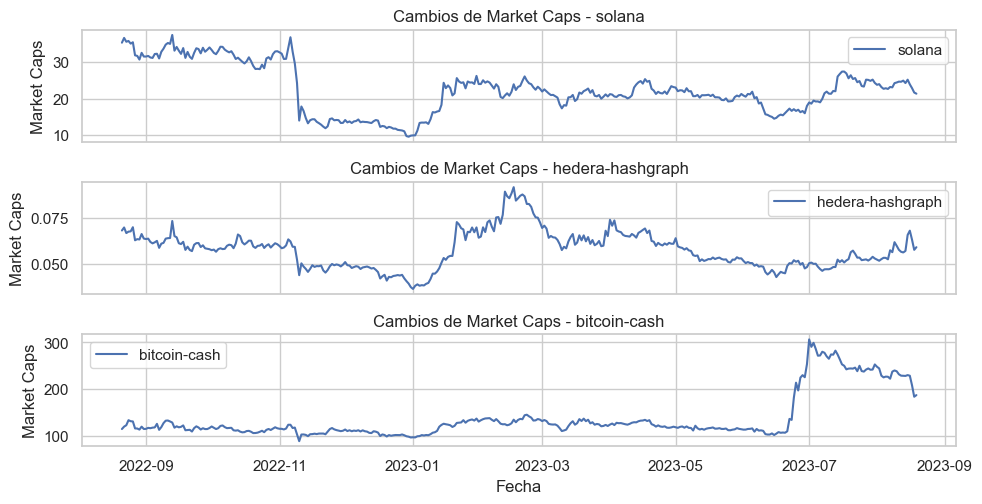

In [52]:
# Filtrar las columnas que necesitamos
data_to_plot = df_criptos[['Cripto', 'prices2']]

# Seleccionar las criptomonedas de interés
criptos_interes = ['solana', 'hedera-hashgraph', 'bitcoin-cash']  # Puedes ajustar las criptomonedas según tus necesidades
data_to_plot = data_to_plot[data_to_plot['Cripto'].isin(criptos_interes)]

# Crear un subplot con tres gráficos para cada criptomoneda
fig, axes = plt.subplots(nrows=3, figsize=(10, 5), sharex=True)

for index, cripto in enumerate(criptos_interes):
    data = data_to_plot[data_to_plot['Cripto'] == cripto]
    ax = axes[index]
    ax.plot(data.index, data['prices2'], label=cripto)
    ax.set_title(f'Cambios de Market Caps - {cripto}')
    ax.set_ylabel('Market Caps')
    ax.legend()

# Ajustar diseño y mostrar los gráficos
plt.tight_layout()
plt.xlabel('Fecha')
plt.show()

#### Datos de empresas de tecnología cuyas acciones se negocian en una bolsa de valores

In [53]:
df_DataTec=pd.read_csv('./DataTec.csv',index_col=0,parse_dates=True)
df_DataTec.head(2)

,Company,Open,High,Low,Close,Volume,Body_Ratio,Clasificación,Daily_Return
2022-08-22,Apple Inc.,168.689264,168.858260,166.154300,166.581772,69026800.0,0.779410,Fuerte Dirección Bajista,0.000000
2022-08-23,Apple Inc.,166.094650,167.715042,165.667178,166.243759,54147100.0,0.072812,Indecisión,-0.002029


#### No hay valores faltantes

In [54]:
df_DataTec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 723 entries, 2022-08-22 to 2023-08-17
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Company        723 non-null    object 
 1   Open           723 non-null    float64
 2   High           723 non-null    float64
 3   Low            723 non-null    float64
 4   Close          723 non-null    float64
 5   Volume         723 non-null    float64
 6   Body_Ratio     723 non-null    float64
 7   Clasificación  723 non-null    object 
 8   Daily_Return   723 non-null    float64
dtypes: float64(7), object(2)
memory usage: 56.5+ KB


#### Outliers

No existen outliers en las columnas "Open","High","Low" y "Close" sin embargo en la columna "Volume" hay 50 outliers de los cuales 10 son de "Appel Inc.", 21 de "NVIDIA" y 19 de "Microsoft Corporation".

In [55]:
outliers_tec = Outliers(df_DataTec, columna='Company',var='Volume')

/var/folders/gg/08x9mdfn43q02625840rv79h0000gn/T/ipykernel_3061/1400367369.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_column['Outlier'] = var
/var/folders/gg/08x9mdfn43q02625840rv79h0000gn/T/ipykernel_3061/1400367369.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_column['Outlier'] = var


In [56]:
df_DataTec['Company'].unique()

array(['Apple Inc.', 'Microsoft Corporation'], dtype=object)

En generak se pueden notar los picos y valles tan pronunciados los cuales serían los valores Outliers, sin embargo la naturaleza de los datos nos puede indicar diferentes fechas de interes.

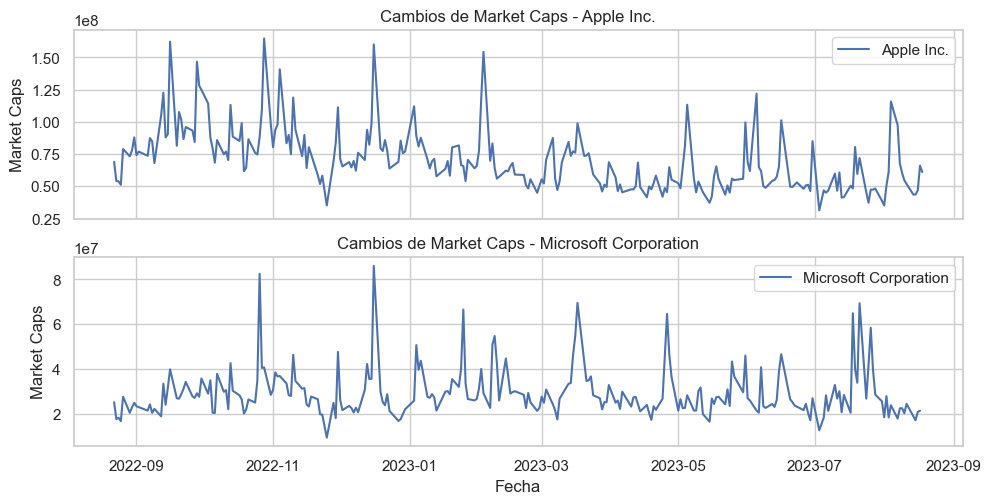

In [57]:
# Filtrar las columnas que necesitamos
data_to_plot = df_DataTec[['Company', 'Volume']]

# Seleccionar las criptomonedas de interés
Empresas = ['Apple Inc.', 'Microsoft Corporation']  # Puedes ajustar las criptomonedas según tus necesidades
data_to_plot = data_to_plot[data_to_plot['Company'].isin(Empresas)]

# Crear un subplot con tres gráficos para cada criptomoneda
fig, axes = plt.subplots(nrows=2, figsize=(10, 5), sharex=True)

for index, empresa in enumerate(Empresas):
    data = data_to_plot[data_to_plot['Company'] == empresa]
    ax = axes[index]
    ax.plot(data.index, data['Volume'], label=empresa)
    ax.set_title(f'Cambios de Market Caps - {empresa}')
    ax.set_ylabel('Market Caps')
    ax.legend()

# Ajustar diseño y mostrar los gráficos
plt.tight_layout()
plt.xlabel('Fecha')
plt.show()

### B) Análisis de valores

#### Market Cap General Criptomonedas
Las 10 monedas de la categoría Layer (1) han experimentado un crecimiento entre Noviembre y Diciembre del 2022, con un tamaño de mercado que casi alcanzó los cien mil millones, para después experimentar ligeras caidas en el mismo. 

In [58]:
crypto_market = df_criptos.groupby(df_criptos.index)[['market_caps2', 'total_volumes2']].sum()

<Axes: title={'center': 'Total market size'}, xlabel='fechas', ylabel='market_caps2'>

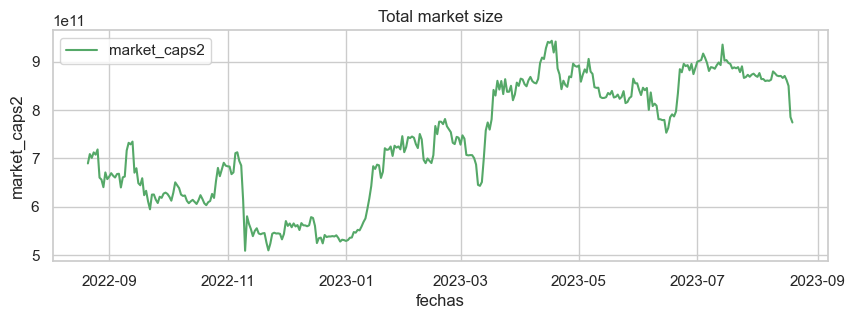

In [59]:
sns.set(style="whitegrid")
fig1, ax1 = plt.subplots(figsize=(10,3))
ax1.set_title('Total market size')
sns.lineplot(data=crypto_market.market_caps2, color="g", label='market_caps2') 

#### Volumen de Mercado (Criptos & Empresas)

In [60]:
tec_volumen = df_DataTec.groupby(df_DataTec.index)[['Volume']].sum()

Los volumenes de mercado si bien el de las criptomonedas es superior que el las compañias técnologías, se observan tendencías en las altas y bajas del los mismos espacios de tiempo, lo cual nos indicaría una relación entre los comportamientos del mercado.

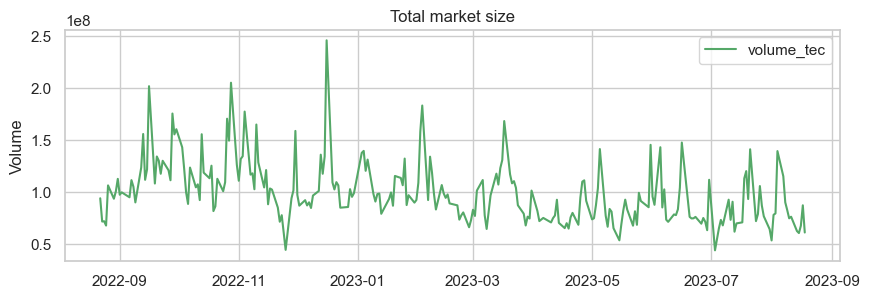

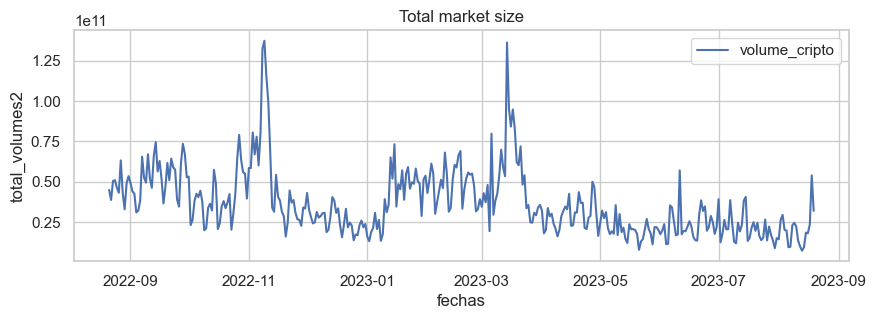

In [61]:
sns.set(style="whitegrid")
fig1, ax1 = plt.subplots(figsize=(10,3))
ax1.set_title('Total market size')
sns.lineplot(data=tec_volumen.Volume, color="g", label='volume_tec') 
ax1.legend()  # Agregar leyenda
plt.show()
fig2, ax2 = plt.subplots(figsize=(10,3))
ax2.set_title('Total market size')
sns.lineplot(data=crypto_market.total_volumes2, color="b", label='volume_cripto') 
ax2.legend()  # Agregar leyenda
plt.show()

#### Market Cap para las diferentes criptomonedas

In [62]:
crypto_top3 = df_criptos[(df_criptos.Ranking <= 3)]
cripto3 = df_criptos[(df_criptos.Ranking) == 3]
crypto4_10 = df_criptos[(df_criptos.Ranking >= 4)]

Se observa una tendencias muy marcadas entre el crecimiento de la capitalización de mercado de la criptomoneda Top 1 "Bitcoin" y las demás criptomonedas, guardando las respectivas distancías de su capitalización.

/Users/alejandrobenjaminnunezguzman/Desktop/DataAnalytics/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Top 3 competidores')

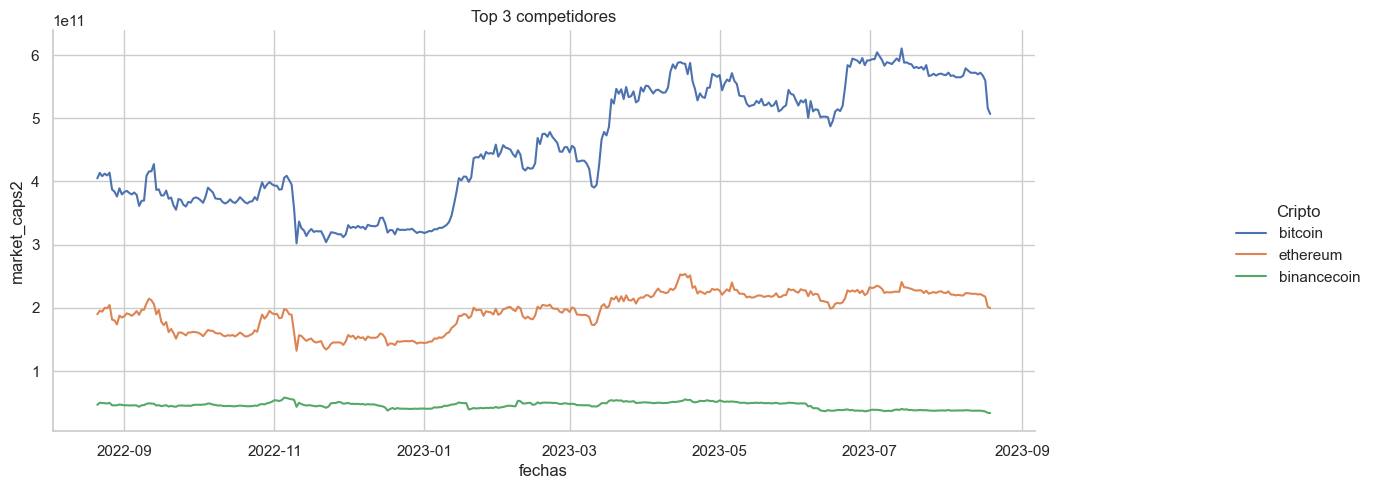

In [63]:
g = sns.relplot(x = crypto_top3.index, y = 'market_caps2', kind = 'line', data = crypto_top3, hue = 'Cripto')
g.fig.set_figwidth(15)
g.ax.set_title("Top 3 competidores")

 Binancencoin tuvo una caída bastante grande entre Junio y Julio.

/Users/alejandrobenjaminnunezguzman/Desktop/DataAnalytics/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'binancencoin')

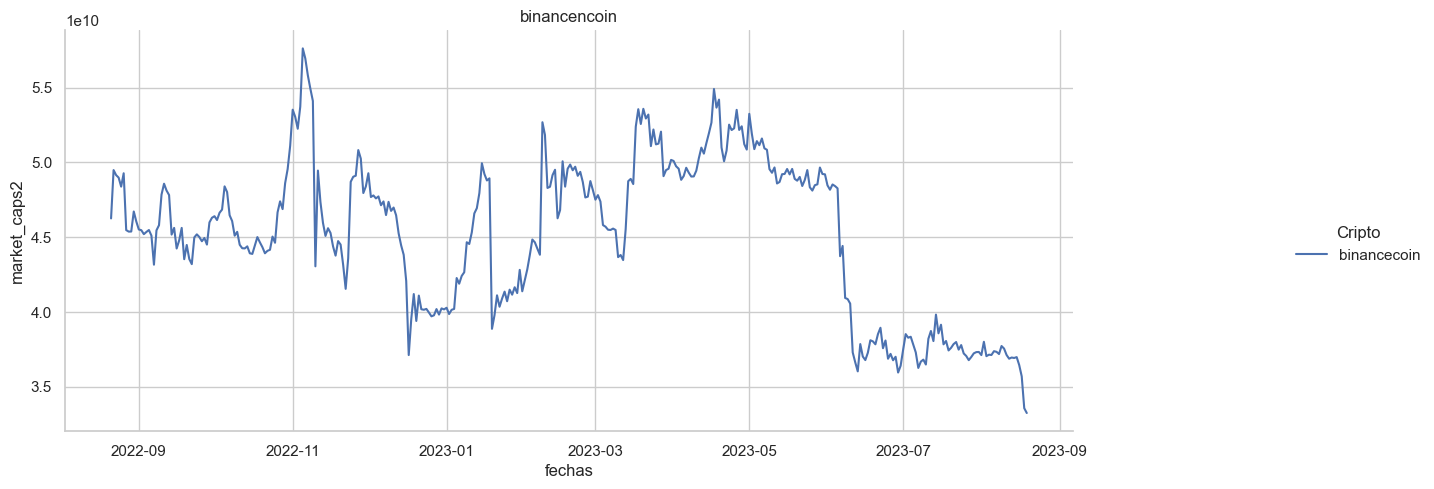

In [64]:
g = sns.relplot(x = cripto3.index, y = 'market_caps2', kind = 'line', data = cripto3, hue = 'Cripto')
g.fig.set_figwidth(16)
g.ax.set_title("binancencoin")

La criptomoneda que mayor caída tuvo en 2022 fue solana, sin embargo se a recuperado de buena manera, y la que nayor crecmiento ha tenido es bitcoin-cash. Las demás parecen tener un comportamiento muy similar con subidas y bajadas en el tiempo.

/Users/alejandrobenjaminnunezguzman/Desktop/DataAnalytics/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Otras monedas del Top')

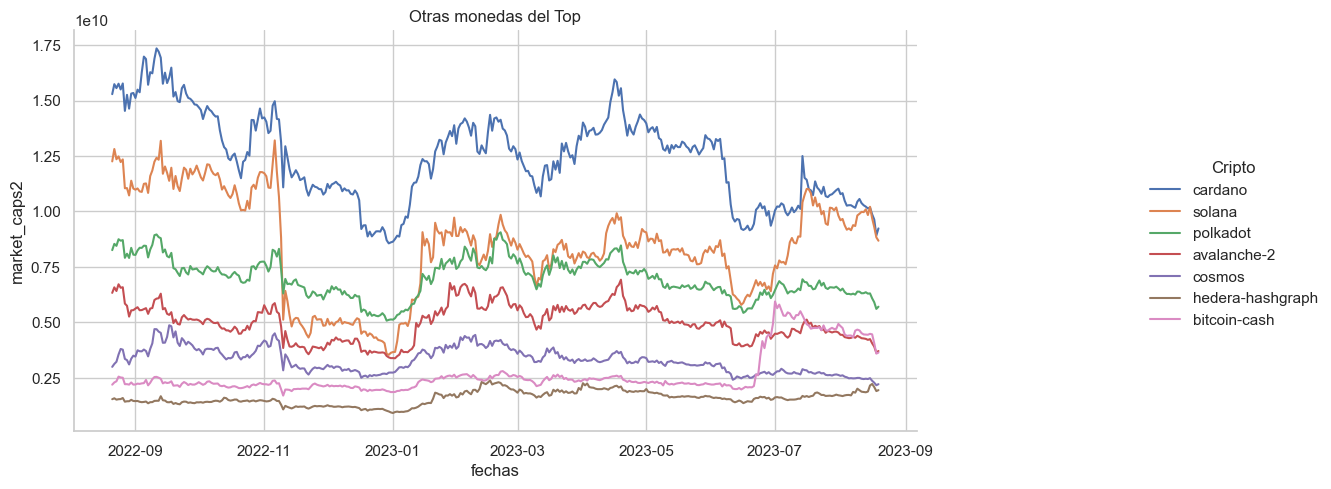

In [65]:
g = sns.relplot(x = crypto4_10.index, y = 'market_caps2', kind = 'line', data = crypto4_10, hue = 'Cripto')
g.fig.set_figwidth(15)
g.ax.set_title("Otras monedas del Top")

#### Análisis de Velas

Close Ratio

Apple Inc. & Microsoft Corporation

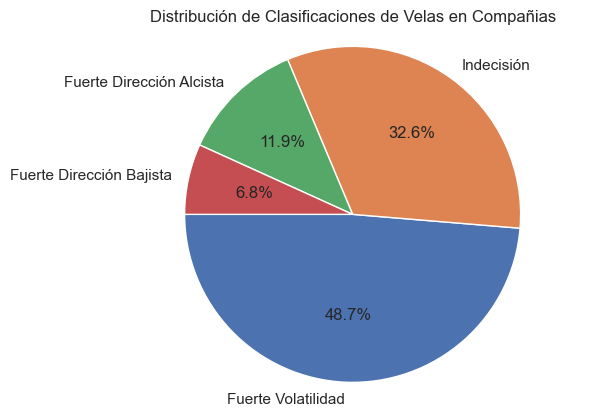

In [66]:
classification_counts = df_DataTec['Clasificación'].value_counts()
plt.pie(classification_counts, labels=classification_counts.index, autopct='%1.1f%%', startangle=180)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribución de Clasificaciones de Velas en Compañias')
plt.show()

Criptomonedas

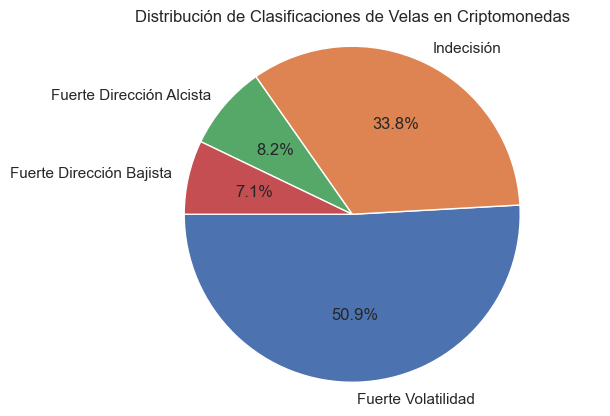

In [67]:
classification_counts2 = df_criptos['Clasificación'].value_counts()
plt.pie(classification_counts2, labels=classification_counts2.index, autopct='%1.1f%%', startangle=180)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribución de Clasificaciones de Velas en Criptomonedas')
plt.show()

#### Porcentaje de retorno respecto al día anterior

Relación entre el precio de cierre de una vela del día anterior y su porcentaje de perdida o ganancía respecto al día actual. 

Apple Inc. & Microsoft Corporation

In [68]:
df_DataTec['Company'].unique()

array(['Apple Inc.', 'Microsoft Corporation'], dtype=object)

In [69]:
Retornos=df_DataTec[df_DataTec.Company=='Microsoft Corporation']['Daily_Return']
count_negative_returns = (Retornos < 0).sum()
count_negative_returns

193

Las siguientes gráficos de histogramas nos muestran la distribución de los retornos diaros del 2022-08-22 al 2023-08-18. 
Se puede observar que para 'Apple Inc.' hay 177 valores por debajo del cero lo que nos indica perdidas en los 362 días, esto no quiere decir que el balance general sea 0. 
Para "Microsoft Corporation" se tienen 193 valores por debajo del cero.
En ambos gráficos se puede observar como la mayoría de retornos díarios están entre los valores de -0.2 y 0.2, por lo que se observa que es complicado tener ganacías diarías. 

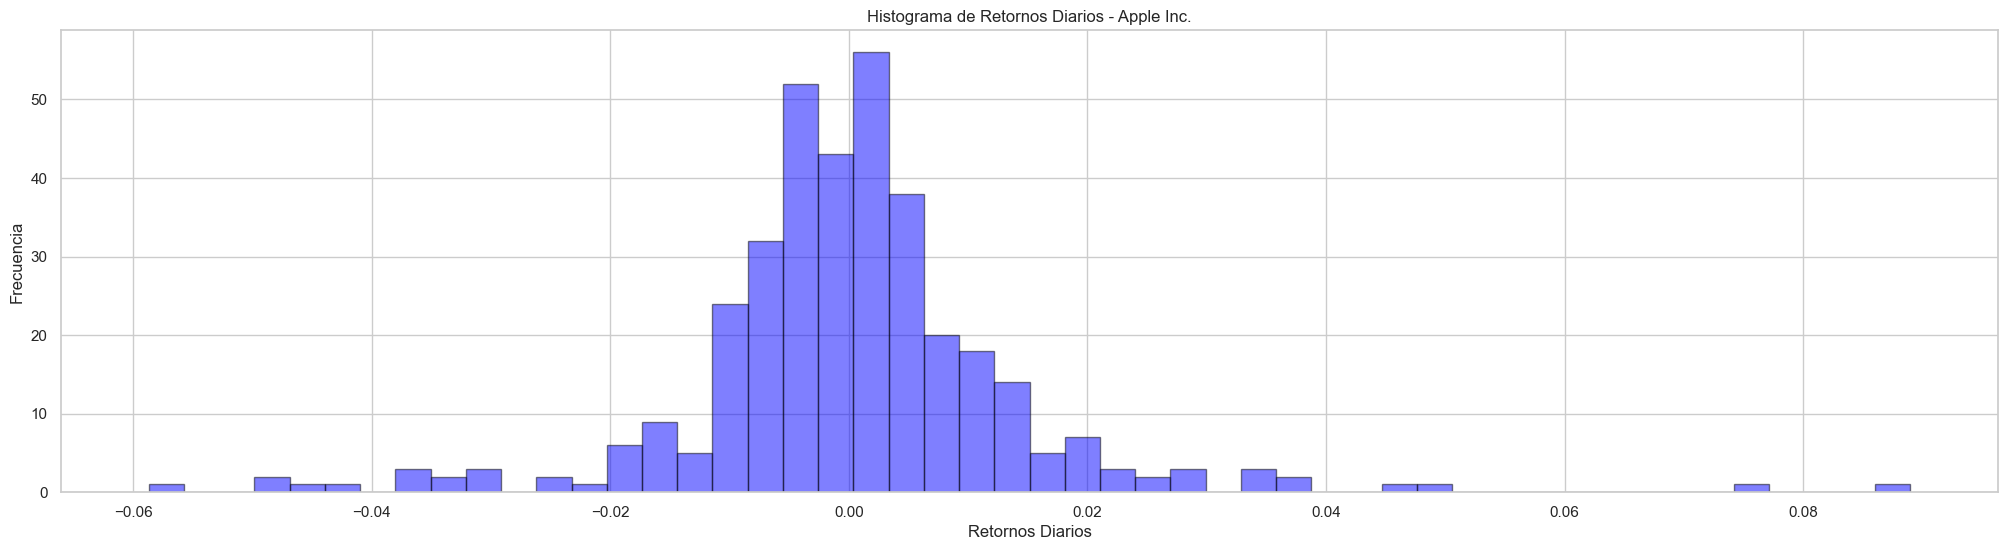

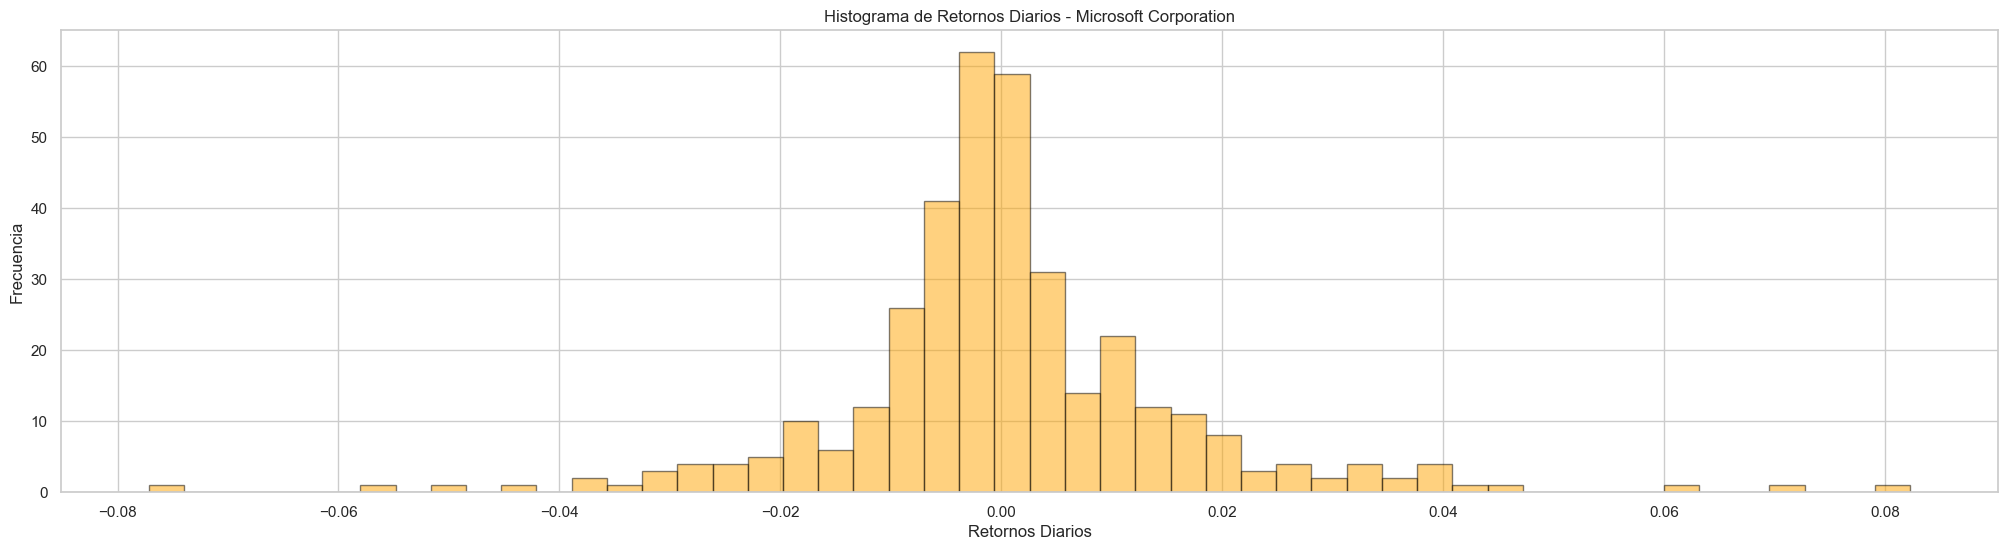

In [70]:
# Crear gráficos de retornos diarios separados por compañía
companies = df_DataTec['Company'].unique()
colors = {'Apple Inc.': 'blue', 'Microsoft Corporation': 'orange'}

for company in companies:
    company_data = df_DataTec[df_DataTec['Company'] == company]
    plt.figure(figsize=(25, 6))
    plt.hist(company_data['Daily_Return'], bins=50, edgecolor='black', alpha=0.5, color=colors[company])
    plt.xlabel('Retornos Diarios')
    plt.ylabel('Frecuencia')
    plt.title(f'Histograma de Retornos Diarios - {company}')
    plt.grid(True)
    plt.show()

Criptomonedas

In [71]:
df_criptos['Daily_Return'].unique()

array([ 0.        , -0.00538121,  0.00604164, ..., -0.11527378,
        0.01791531, -0.00213333])

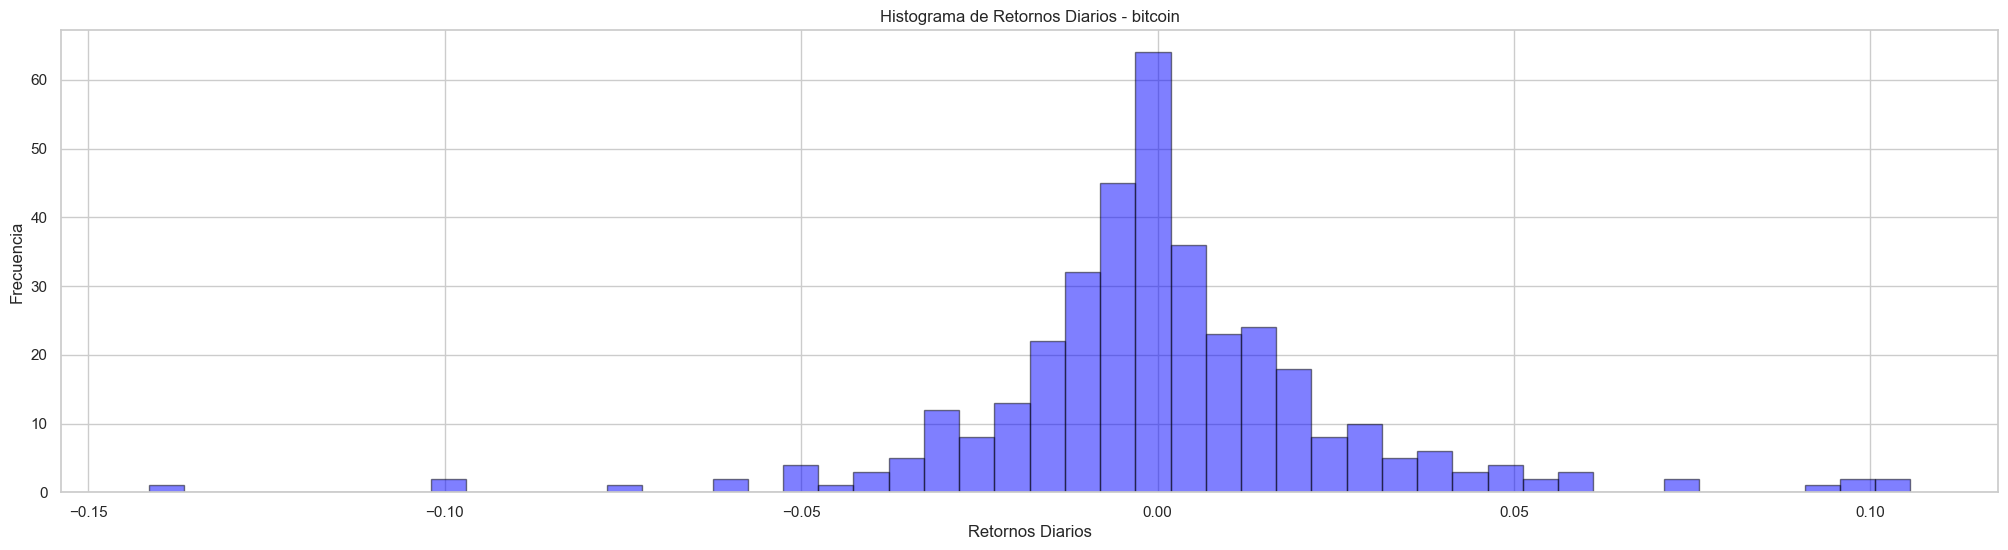

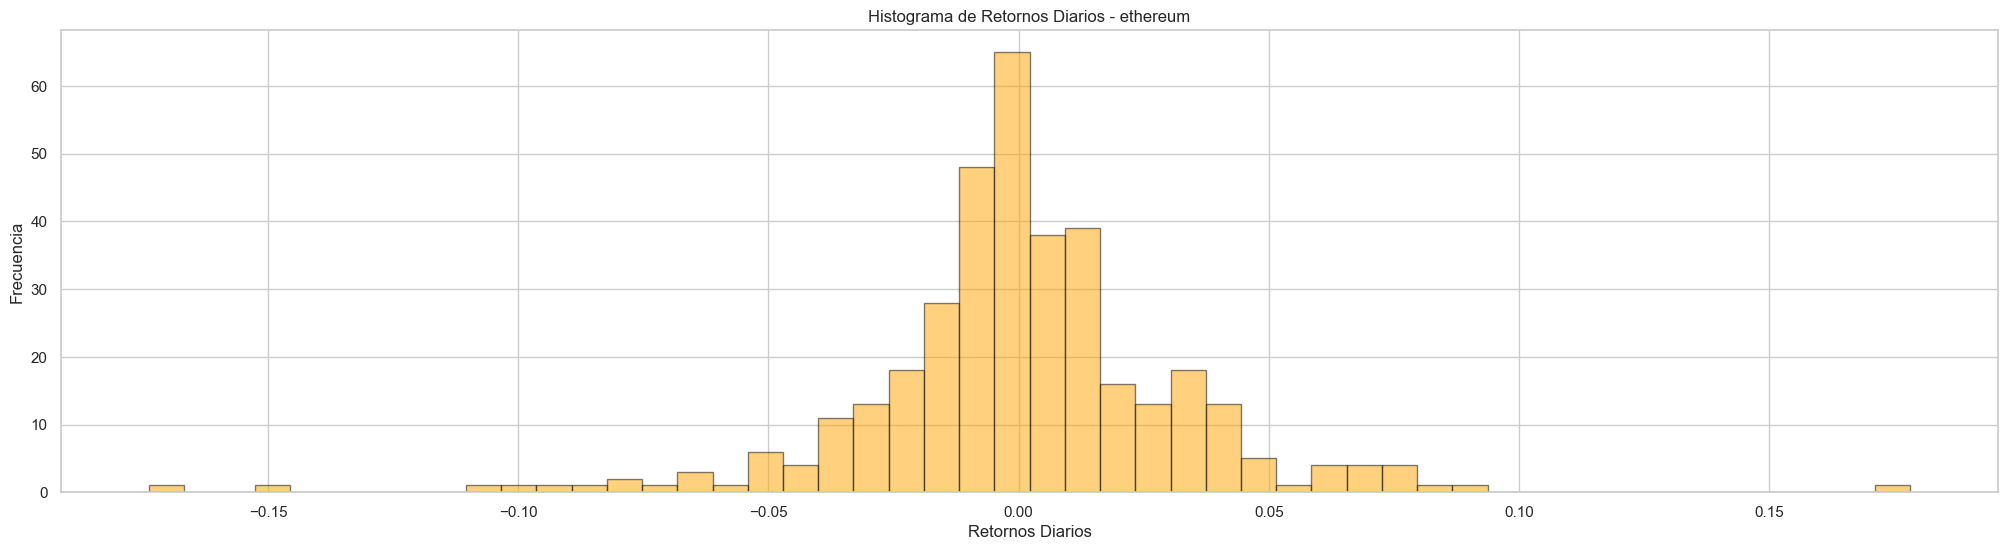

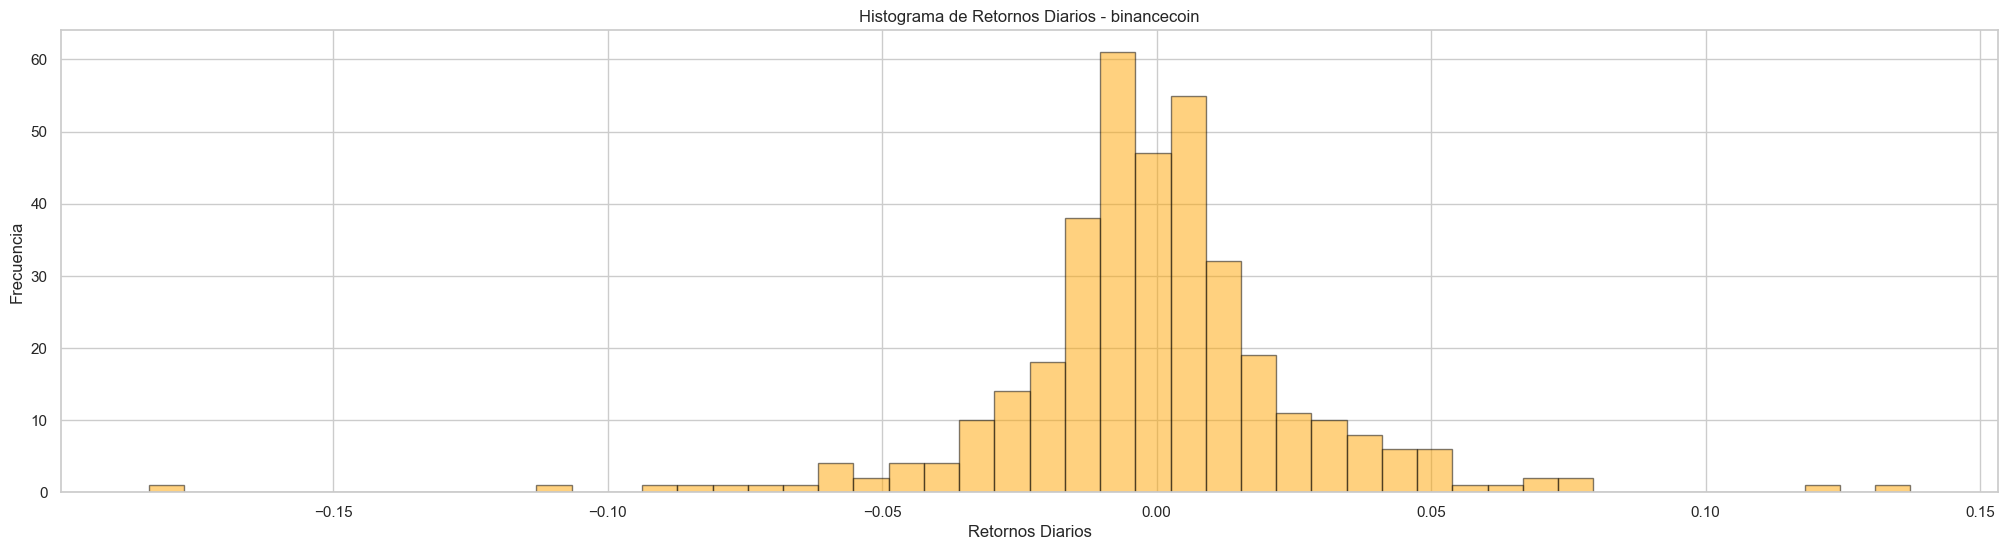

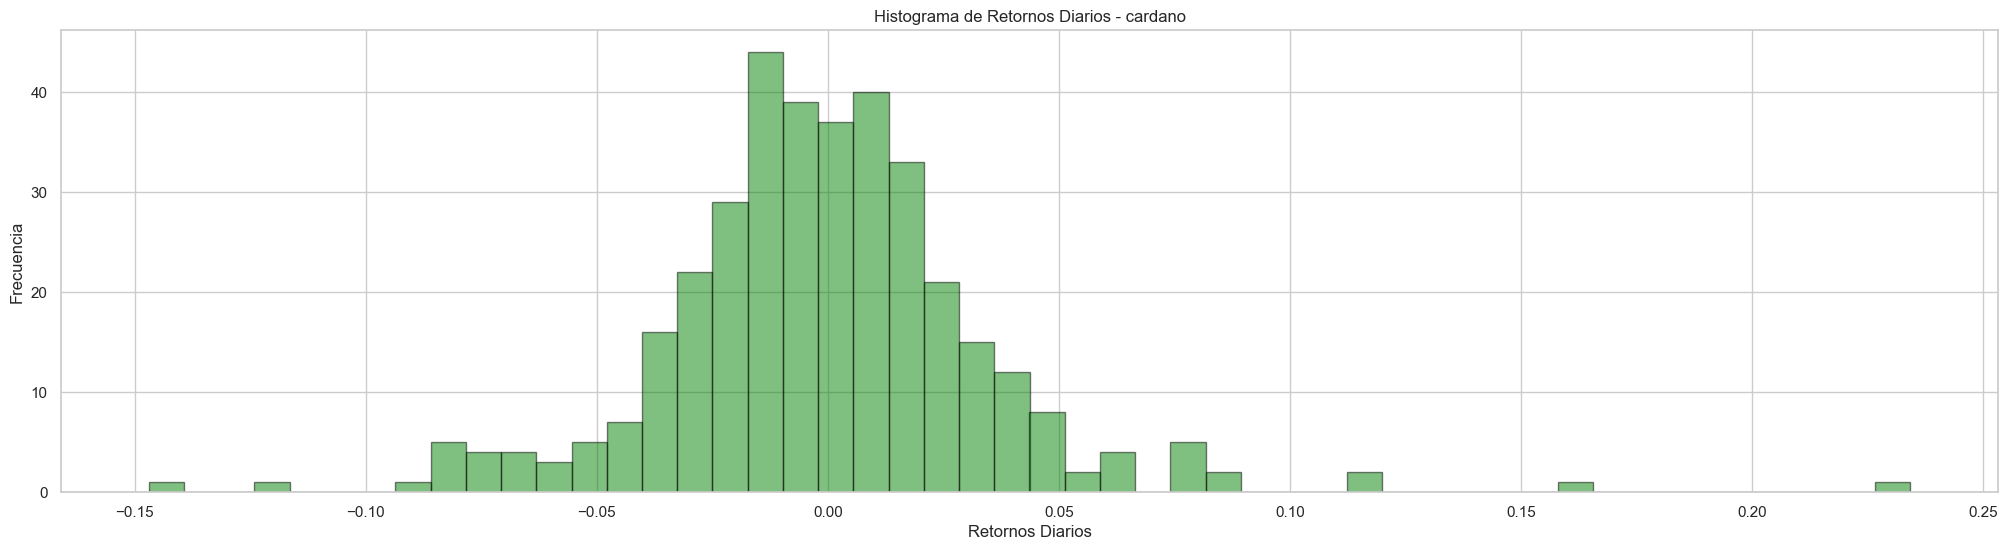

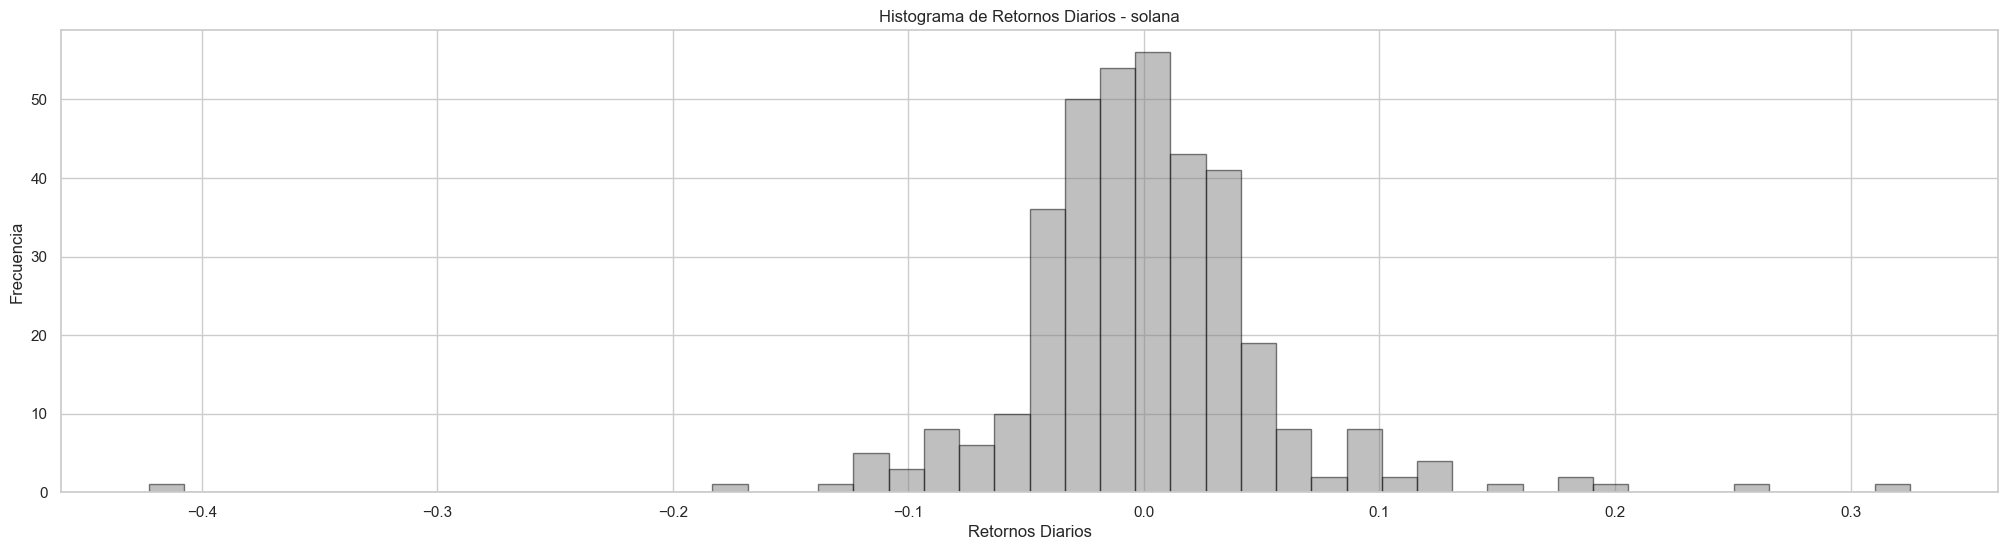

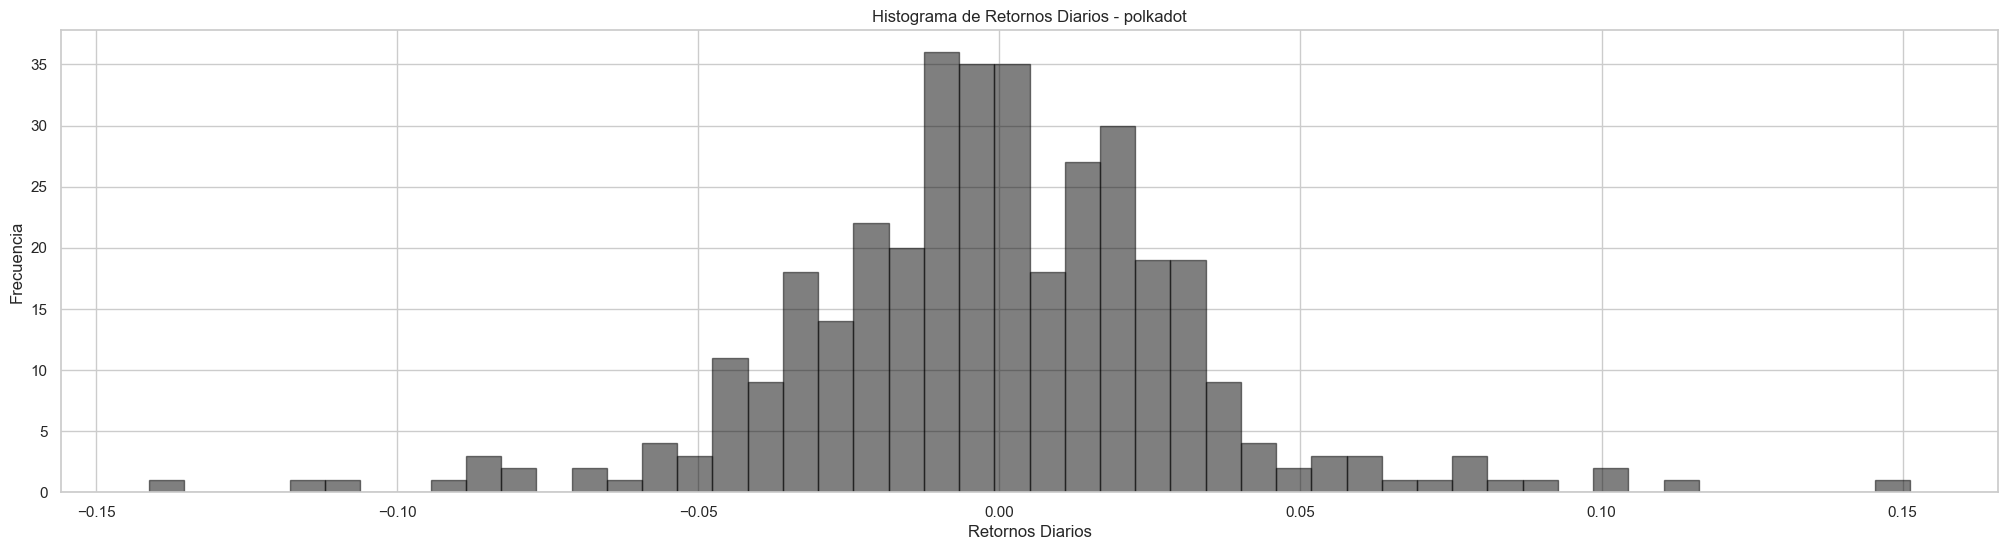

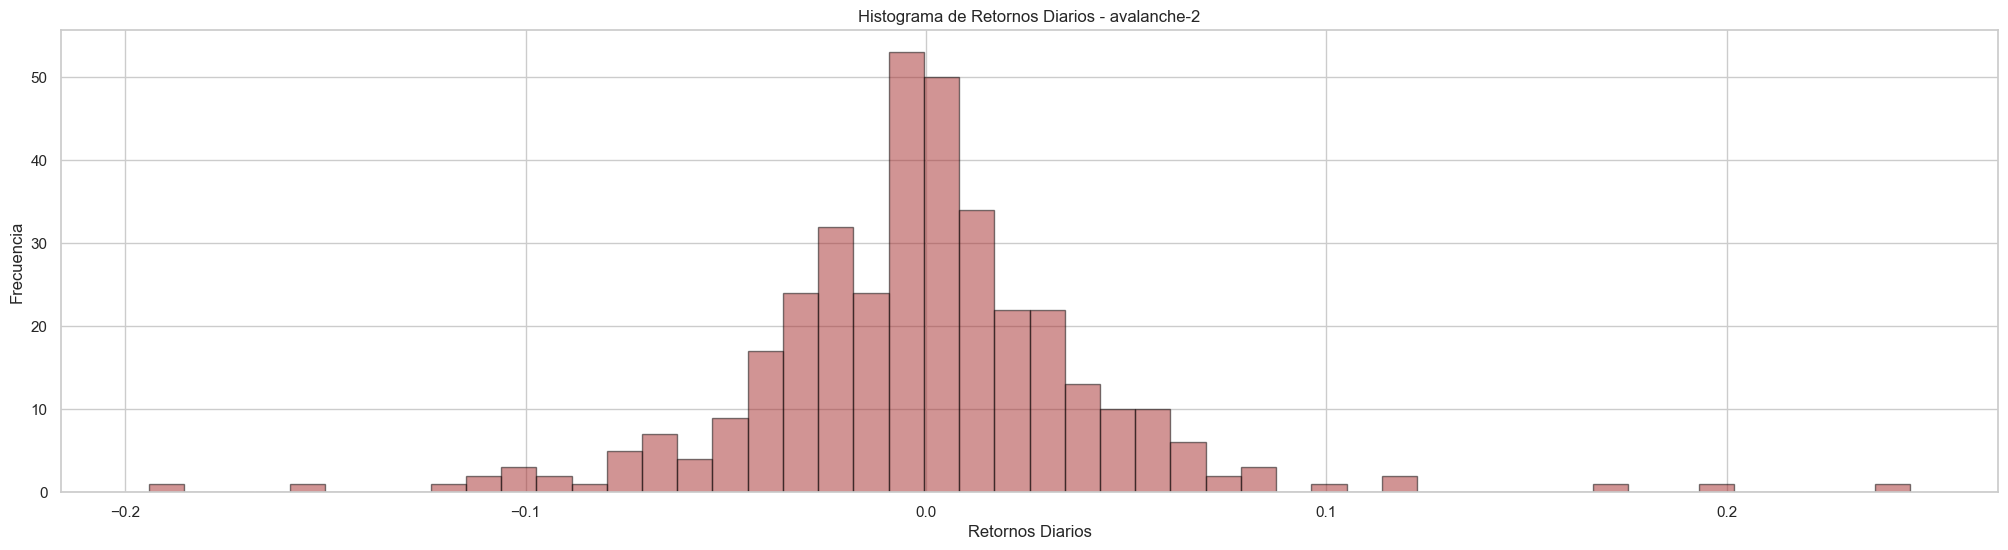

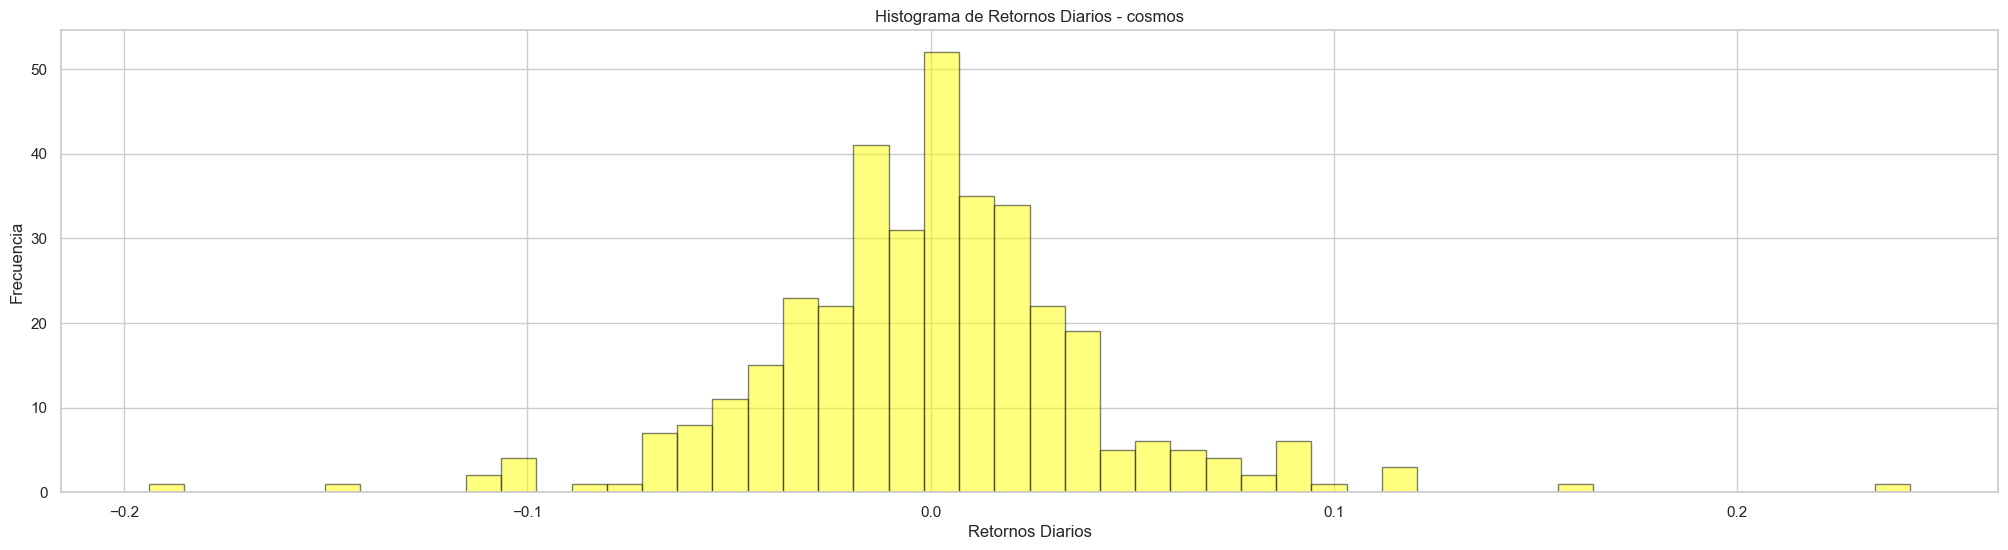

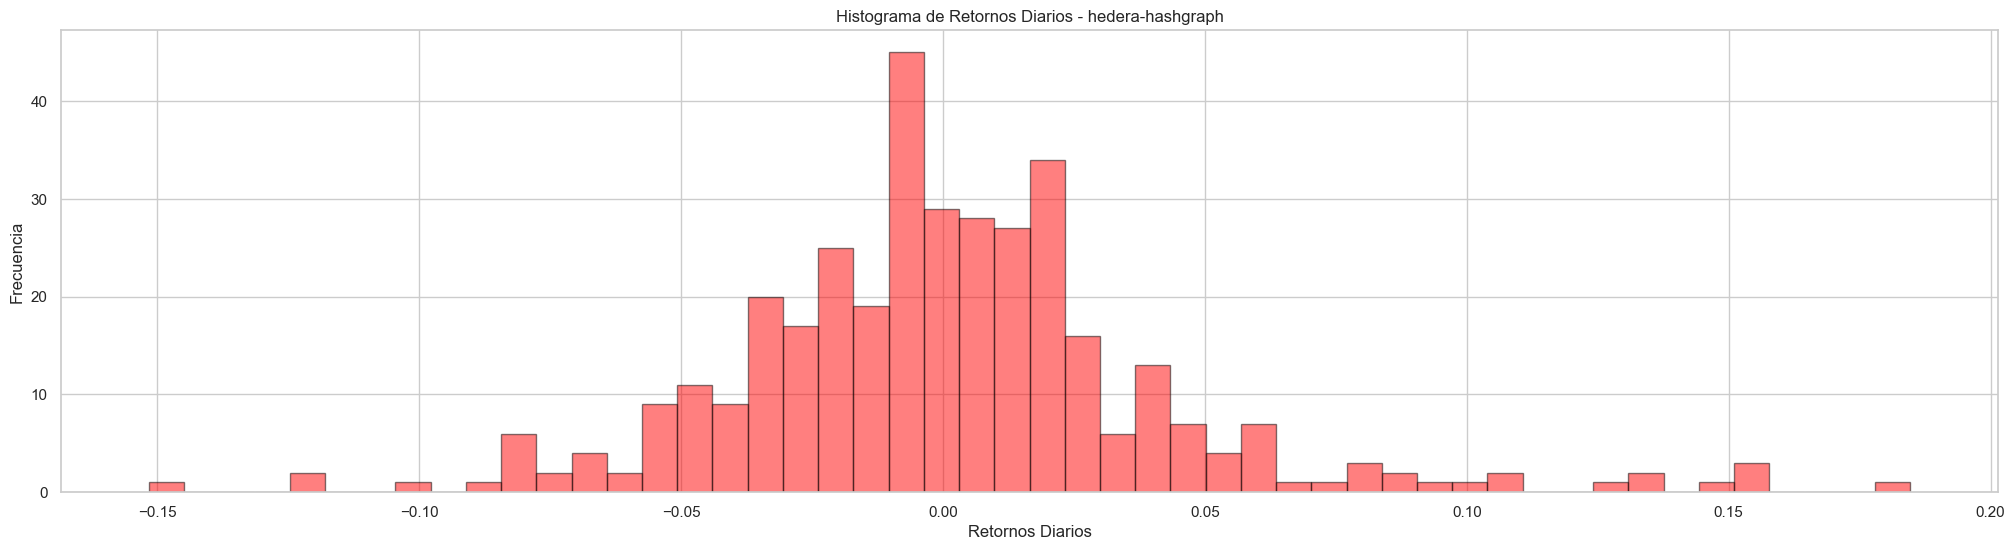

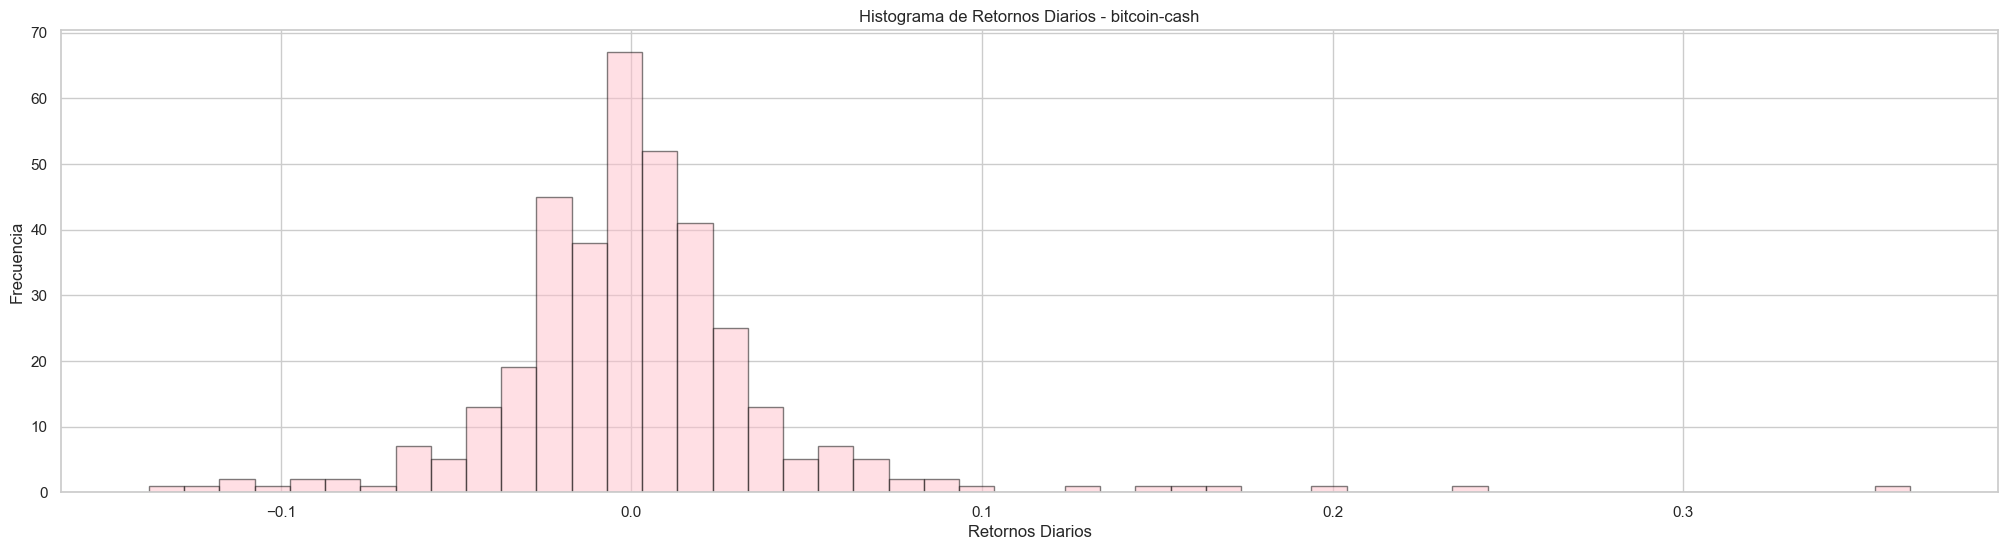

In [72]:
# Crear gráficos de retornos diarios separados por compañía

criptos = df_criptos['Cripto'].unique()
colors = {'bitcoin': 'blue', 'ethereum': 'orange','binancecoin':'orange','cardano':'green'
          ,'solana':'grey','polkadot':'black','avalanche-2':'brown','cosmos':'yellow'
          ,'hedera-hashgraph':'red','bitcoin-cash':'pink'}

for cripto in criptos:
    cripto_data = df_criptos[df_criptos['Cripto'] == cripto]
    plt.figure(figsize=(25, 6))
    plt.hist(cripto_data['Daily_Return'], bins=50, edgecolor='black', alpha=0.5, color=colors[cripto])
    plt.xlabel('Retornos Diarios')
    plt.ylabel('Frecuencia')
    plt.title(f'Histograma de Retornos Diarios - {cripto}')
    plt.grid(True)
    plt.show()